![drawing](https://scp-com.s3.amazonaws.com/314a1a15/University_of_Tennessee_at_Chattanooga_logo.svg.png)
<br>
![drawing](https://i.imgur.com/GIZFPgy.png)

# Automated Event Grouping by Impulse Signature

![drawing](https://cdn.dribbble.com/users/2097701/screenshots/4143230/medusa_logo.jpg)

#### Description
This notebook demonstrates a machine learning algorithm for classifying impulse waveforms.

#### Configuration
Adjust the parameters for the experiment such as the number and complexity of the generated waveforms, and the number of feature dimensions (equal to number of polynomial coefficients) that will train the algorithm.

In [13]:
samples = 200 # number of samples
complexity = 3 # max poles and/or zeros for impulses
dimensions = 18 # feature dimensions (# of coefficients in polynomial fit)
noise = None # magnitude of generated signal noise, or None to disable
downsample = None # downsampling factor for generated signal, or None to disable
k_max = 20 # max k to try when optimizing

#### Generate example data
Using scipy's signal module, generate impulses with the specified complexity and number of samples. Assign each generated waveform a group based on the number of poles, zeros, and gain. Display the first three waveforms for reference.

IntProgress(value=0, description='Progress', max=200)

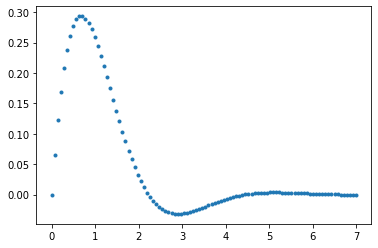

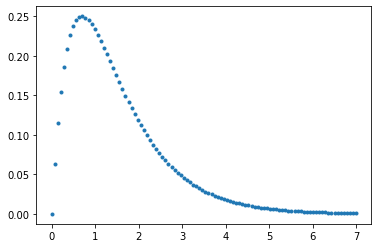

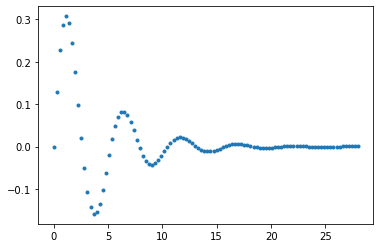

In [15]:
from random import randint
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
x = []
y = []
poles = []
zeros = []
gain = []
group = []
progress = widgets.IntProgress(value=0,max=samples,description='Progress')
display(progress)
for i in range(samples):
    poles += [randint(1,complexity)]
    zeros += [randint(1,complexity)]
    gain += [randint(1,complexity)]
    x_new,y_new = signal.impulse(([1.0],[poles[i],zeros[i],gain[i]]))
    if noise is not None:
        x_new += np.random.normal(0,noise,len(x_new))
    if downsample is not None:
        x_new = signal.decimate(x_new,downsample)
        y_new = signal.decimate(y_new,downsample)
    x += [x_new]
    y += [y_new]
    group += [(poles[i] - 1) + complexity*(zeros[i] - 1) + complexity*complexity*(gain[i] - 1)]
    progress.value = i
plt.show(plt.plot(x[0],y[0],'.'))
plt.show(plt.plot(x[1],y[1],'.'))
plt.show(plt.plot(x[2],y[2],'.'))

#### Polynomial fit
Using the numpy library, find the polynomial coefficients up to a degree specified by `dimension` for each waveform. Display comparisons of the first three polynomial fits (orange line) to their respective waveforms (blue dots)

IntProgress(value=0, description='Progress', max=200)

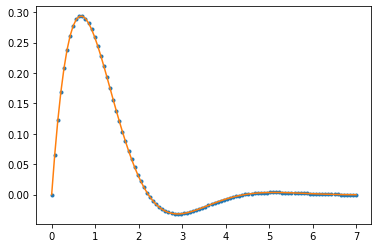

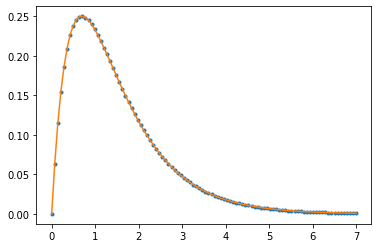

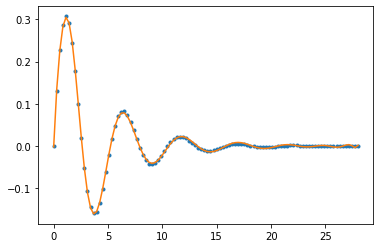

In [16]:
import numpy as np
x_fit = []
y_fit = []
coeffs = []
progress = widgets.IntProgress(value=0,max=samples,description='Progress')
display(progress)
for i in range(len(x)):
    x_fit += [np.linspace(min(x[i]),max(x[i]),100)]
    coeffs += [np.polyfit(x[i],y[i],dimensions)]
    y_fit += [np.poly1d(coeffs[i])(x_fit[i])]
    progress.value = i
plt.show(plt.plot(x[0],y[0],'.',x_fit[0],y_fit[0],'-'))
plt.show(plt.plot(x[1],y[1],'.',x_fit[1],y_fit[1],'-'))
plt.show(plt.plot(x[2],y[2],'.',x_fit[2],y_fit[2],'-'))

#### Feature scaling
Now that we have determined the features of each waveform (the polynomial coefficients), they must be scaled before training the algorithm. This is done with the sklearn.preprocessing module.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(coeffs)
features = scaler.transform(coeffs)

#### Split data into train and test sets
The scaled features are split into a training set and a testing set. The ratio can be adjusted by the `test_size` parameter.

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,group,test_size=0.30)

#### Find optimal number of neighbors
Apply sklearn's k-nearest neighbors (KNN) algorithm to the training set in multiple iterations, incrementing k. Keep track of error rates to help determine the k value that optimizes accuracy. K represents the number of neighbors (starting with the nearest) that affect which group a waveform is assigned to.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
progress = widgets.IntProgress(value=1,min=1,max=k_max-1,description='Progress')
display(progress)
for k in range(1,k_max):
    progress.value = k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))
k_best = 1
while error_rate[k_best - 1] >= error_rate[k_best]:
    k_best += 1
print('Optimal k value:',k_best)
print('Error rate:',error_rate[k_best])

IntProgress(value=1, description='Progress', max=19, min=1)

Optimal k value: 3
Error rate: 0.1


#### Error rate analysis
Plot error rates as a function of k. Increasing training set size will reduce error rates for all k values. Increasing complexity will increase error rates.

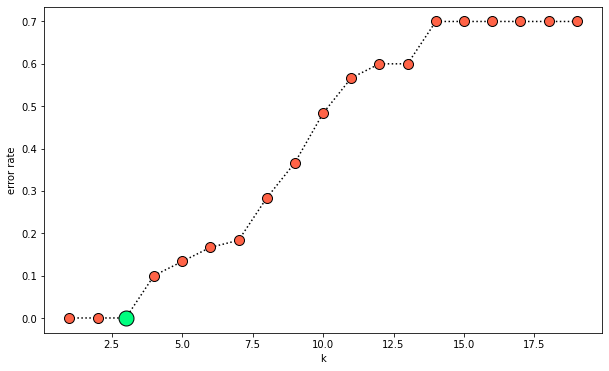

In [30]:
plt.figure(figsize=(10,6))
plt.plot(range(1,k_max),error_rate,'ko',ls=':',markerfacecolor='tomato', markersize=10)
plt.plot(k_best,error_rate[k_best - 1],'ko',markerfacecolor='springgreen',markersize=15)
plt.xlabel('k')
plt.ylabel('error rate')
plt.show()

#### Apply KNN and make predictions
Create the KNN model and generate predicted outputs for the test data.

In [31]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(x_train,y_train)
pred = knn.predict(x_test)

#### Confusion matrix
Print the confusion matrix comparing test data outputs to predicted outputs.

In [32]:
from sklearn.metrics import classification_report,confusion_matrix
from pandas import DataFrame
display(DataFrame(confusion_matrix(y_test,pred)))

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Classification report
Report accuracy and other details to evaluate the effectiveness of the KNN model.

In [35]:
print(classification_report(y_test,pred,zero_division=False))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

#### Results
Show test results on a pie chart.

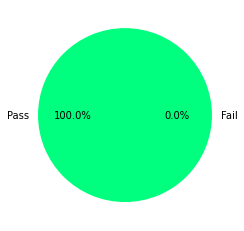

In [36]:
matches = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        matches += 1
pie = [matches,len(pred) - matches]
fig = plt.pie(pie,labels=['Pass','Fail'],autopct='%1.1f%%',colors=['springgreen','tomato'])